In [1]:
%%capture
pip install emoji

In [2]:
%%capture
pip install langdetect

In [3]:
%%capture
pip install lime

In [4]:
%%capture
pip install vaderSentiment

In [5]:
%%capture
!pip install imbalanced-learn

In [6]:
%%capture
import nltk
nltk.download('punkt_tab')

In [7]:
%%capture
pip install pandas numpy seaborn

In [8]:
%%capture
pip install textblob

In [9]:
%%capture
pip install wordcloud

In [10]:
%%capture
!pip install mlflow
#!pip install datasets

In [11]:
%%capture
#pip install xgboost

In [12]:
%%capture
#pip install transformers

In [13]:
%%capture
#pip install torch

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
 # from transformers import pipeline

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve,confusion_matrix
from langdetect import detect, DetectorFactory, LangDetectException

# sentiment_analysis_pipeline.py


import mlflow
import mlflow.sklearn
import mlflow.xgboost
#import mlflow.transformers



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier
#from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
#from datasets import Dataset
#import torch

import warnings
warnings.filterwarnings('ignore')



#import nltk; nltk.download('punkt'); nltk.download('wordnet'); nltk.download('stopwords')

In [15]:
%%capture
#nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')

# 1.0 Load Data and Data Understanding

In [16]:
data = pd.read_csv('aliexpressdata.csv')
df1 = pd.DataFrame(data)
df1.head()

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
0,6.01E+16,"Same to this one as well, very classy and soft...",5.0,2024-11-08,United States
1,6.01E+16,"Beautiful colors, exactly what I wanted, but ...",4.0,2024-10-15,United States
2,6.01E+16,"This is top notch scarf, so soft and classy no...",5.0,2024-11-08,United States
3,6.01E+16,Item was great; would buy from seller again!,5.0,2024-11-10,United States
4,6.01E+16,Nice item,5.0,2024-10-01,United States


In [17]:
# check data shape and info
print(df1.shape)
print('------------------')
df1.info()

(8492, 5)
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8492 entries, 0 to 8491
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REVIEW_ID       8492 non-null   object 
 1   REVIEW_CONTENT  7869 non-null   object 
 2   RATING          8128 non-null   float64
 3   DATE            8492 non-null   object 
 4   COUNTRY         8492 non-null   object 
dtypes: float64(1), object(4)
memory usage: 331.8+ KB


In [18]:
# code to count duplicates
duplicates = df1[df1.duplicated()]
print("Number of duplicate rows:", len(duplicates))

print('---------------------------------------------')

# mising data
df1.isnull().sum()

Number of duplicate rows: 80
---------------------------------------------


REVIEW_ID           0
REVIEW_CONTENT    623
RATING            364
DATE                0
COUNTRY             0
dtype: int64

# Load the 2nd File, clean it and Merge with the first file

In [19]:
import pandas as pd
import numpy as np
import re
from dateutil.parser import parse

# Step 1: Read the data
df2 = pd.read_csv('aliexpressdata2.csv', header=[0,1], skipinitialspace=True)

# Step 2: Fix the double headers
df2.columns = ['Review ID', 'Review Content', 'Rating', 'Date', 'Country']
df2.head()

,Review ID,Review Content,Rating,Date,Country
0,R2PALAAI6TFDFA,Pros:\n* Easy installation.\n* Good spray qual...,3,2025-03-25,United States
1,R3L6U6PSXIYTIR,The first few times using it the stream is awe...,3,2025-03-21,United States
2,R3MVC57KX3HJ26,It works great without restrictor but the hold...,3,2025-04-08,United States
3,R3UYPWQEV6JHRS,"Got here quick, easy and convenient to install...",3,2025-03-26,United States
4,R3DUI9YX2553QI,Es una buena regadera al principio pero al poc...,3,2025-04-01,United States


In [20]:
# Step 3: Clean messy characters safely
def fix_text(text):
    if pd.isnull(text):
        return text
    text = str(text)
    text = (text
            .replace('â', "'")
            .replace('â', '-')
            .replace('â', '"')
            .replace('â', '"')
            .replace('â¢', '•')
            .replace('â¦', '...')
            .replace('â“', '-')
           )
    return text

df2['Review Content'] = df2['Review Content'].apply(fix_text)

# Step 4: Define helper function to check if a string is a valid date
def is_valid_date(s):
    try:
        parse(str(s), fuzzy=False)
        return True
    except:
        return False

# Step 5: Merge misplaced comments into 'Review Content'
def merge_misplaced_comments(row):
    if pd.isnull(row['Review Content']) or str(row['Review Content']).strip() == '':
        parts = []
        # Check if Review ID is not starting with "R" and not empty
        if pd.notnull(row['Review ID']) and not str(row['Review ID']).startswith('R'):
            parts.append(str(row['Review ID']).strip())
        # Check if Date is not a real date and not empty
        if pd.notnull(row['Date']) and not is_valid_date(row['Date']):
            parts.append(str(row['Date']).strip())
        # Merge parts if any
        if parts:
            return ' '.join(parts)
    return row['Review Content']

df2['Review Content'] = df2.apply(merge_misplaced_comments, axis=1)

# Step 6: Drop rows where 'Review Content' or 'Rating' are still missing
df2 = df2.dropna(subset=['Review Content', 'Rating'])

# Step 7: Reset index
df2 = df2.reset_index(drop=True)

# Now your df is ready!
print(df2[['Review Content', 'Rating']].head())


                                      Review Content  Rating
0  Pros:\n* Easy installation.\n* Good spray qual...       3
1  The first few times using it the stream is awe...       3
2  It works great without restrictor but the hold...       3
3  Got here quick, easy and convenient to install...       3
4  Es una buena regadera al principio pero al poc...       3


# Merge the file

In [21]:
import pandas as pd

# Step 1: Load the two data files
#df1 = pd.read_csv('file1.csv', delimiter='\t')  # First file (headings in UPPERCASE)
#df2 = pd.read_csv('file2.csv', delimiter='\t')  # Second file (headings in MixedCase)

# Step 2: Standardize the column names (make both consistent)
df1.columns = ['Review ID', 'Review Content', 'Rating', 'Date', 'Country']
df2.columns = ['Review ID', 'Review Content', 'Rating', 'Date', 'Country']

# Step 3: Concatenate both DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Step 4 (Optional): Drop exact duplicates if any
combined_df = combined_df.drop_duplicates()

# Step 5 (Optional but recommended): Reset index
combined_df = combined_df.reset_index(drop=True)

# Final DataFrame is ready!
combined_df.head()


# Save
combined_df.to_csv('aliexpressdata_cleaned.csv', index=False)

In [22]:
# check data shape and info
print(combined_df.shape)
print('------------------')
combined_df.info()

(12620, 5)
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12620 entries, 0 to 12619
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review ID       12619 non-null  object 
 1   Review Content  12042 non-null  object 
 2   Rating          12279 non-null  float64
 3   Date            12609 non-null  object 
 4   Country         12620 non-null  object 
dtypes: float64(1), object(4)
memory usage: 493.1+ KB


In [23]:
# check index and columns
print(combined_df.index)
print('------------------')
print(combined_df.columns)

RangeIndex(start=0, stop=12620, step=1)
------------------
Index(['Review ID', 'Review Content', 'Rating', 'Date', 'Country'], dtype='object')


In [24]:
# Print one example where RATING == 1
example_review = combined_df[combined_df['Rating'] == 1]['Review Content'].iloc[0]
example_review

'I received my package; however, I had to reach out to the seller beforehand regarding their choice of delivery courier, Better Trucks. This company is known for its low ratings and frequent delivery issues. When I raised my concerns with the seller, they completely dismissed them and simply told me to contact my local post office—which makes no sense, as Better Trucks is not a postal service.\n\nAlthough my package did eventually arrive, it was very late in the evening. Due to the seller’s poor customer service and lack of concern for consumer feedback, I will not be ordering from them again. AliExpress used to rely on DHL, a reputable courier, and I’m unsure why that has changed.'

In [25]:
# Print one example where RATING == 3
example_review = combined_df[combined_df['Rating'] == 3]['Review Content'].iloc[0]
example_review


'I order a 22 and it looks like a 16 inch but other than that it’s very soft. You should but it but if u want a long one grab a 30.'

In [26]:
# Print one example where RATING == 5
example_review = combined_df[combined_df['Rating'] == 5]['Review Content'].iloc[0]
example_review


'Same to this one as well, very classy and soft, no bad smells. Perfect for my neck too. Vibrant colors '

In [27]:
print(combined_df.shape)

print("--------------")

#check data info
combined_df.info()

(12620, 5)
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12620 entries, 0 to 12619
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review ID       12619 non-null  object 
 1   Review Content  12042 non-null  object 
 2   Rating          12279 non-null  float64
 3   Date            12609 non-null  object 
 4   Country         12620 non-null  object 
dtypes: float64(1), object(4)
memory usage: 493.1+ KB


In [28]:
# code to count duplicates
duplicates = combined_df[combined_df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

print('---------------------------------------------')

# mising data
combined_df.isnull().sum()

Number of duplicate rows: 0
---------------------------------------------


Review ID           1
Review Content    578
Rating            341
Date               11
Country             0
dtype: int64

In [29]:
# check the data statistics
combined_df.describe(include='all').round(2)

,Review ID,Review Content,Rating,Date,Country
count,12619,12042,12279.00,12609,12620
unique,10490,11718,NaN,1647,109
top,6.01E+16,Good,NaN,2025-03-24,United Kingdom
freq,574,38,NaN,144,4379
mean,NaN,NaN,3.55,NaN,NaN
std,NaN,NaN,1.50,NaN,NaN
min,NaN,NaN,1.00,NaN,NaN
25%,NaN,NaN,2.00,NaN,NaN
50%,NaN,NaN,4.00,NaN,NaN
75%,NaN,NaN,5.00,NaN,NaN


# 2.0 Quick Exploratory Data Analysis

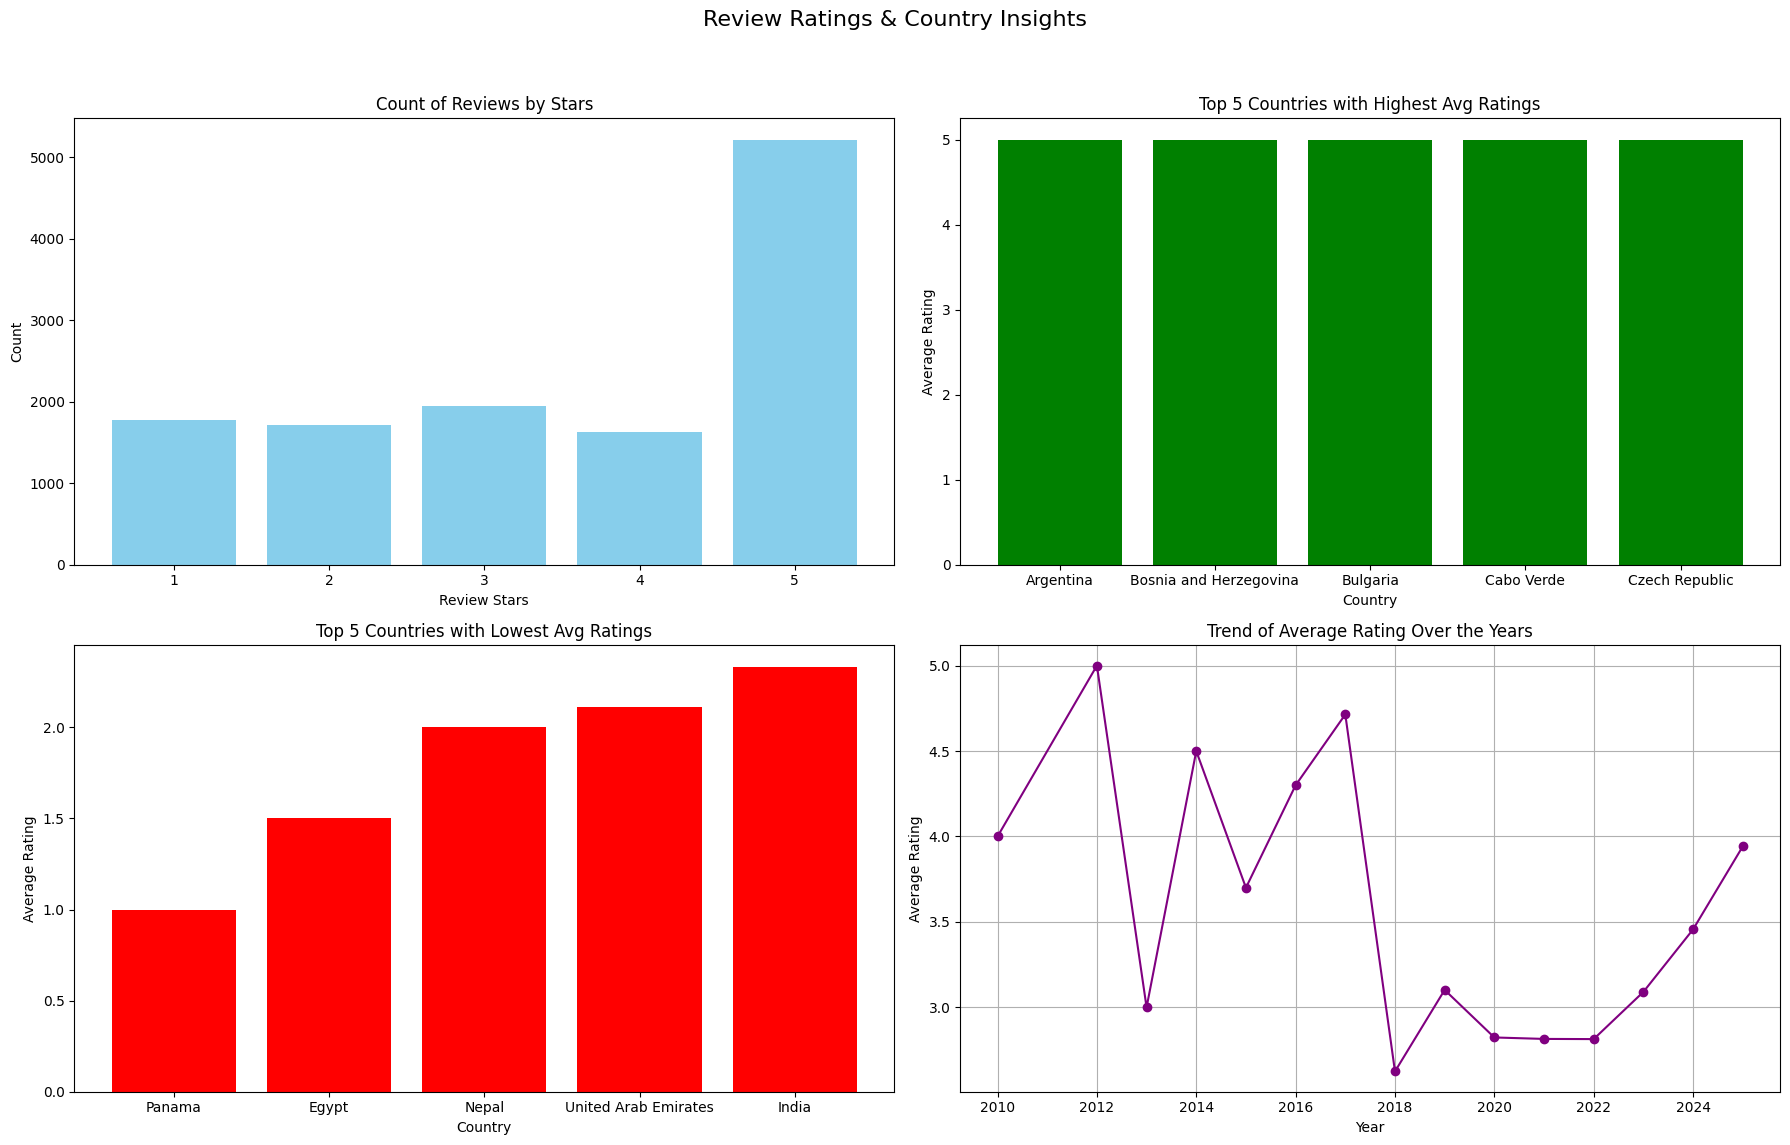

In [30]:
import matplotlib.pyplot as plt

# Prepare figure with 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Review Ratings & Country Insights', fontsize=16)

# --- 1. Count of Reviews by Stars ---
rating_counts = combined_df['Rating'].value_counts().sort_index()
axs[0, 0].bar(rating_counts.index, rating_counts.values, color='skyblue')
axs[0, 0].set_title('Count of Reviews by Stars')
axs[0, 0].set_xlabel('Review Stars')
axs[0, 0].set_ylabel('Count')

# --- 2. Top 5 Countries with Highest Ratings ---
top_5_highest = combined_df.groupby('Country')['Rating'].mean().nlargest(5)
axs[0, 1].bar(top_5_highest.index, top_5_highest.values, color='green')
axs[0, 1].set_title('Top 5 Countries with Highest Avg Ratings')
axs[0, 1].set_xlabel('Country')
axs[0, 1].set_ylabel('Average Rating')

# --- 3. Top 5 Countries with Lowest Ratings ---
top_5_lowest = combined_df.groupby('Country')['Rating'].mean().nsmallest(5)
axs[1, 0].bar(top_5_lowest.index, top_5_lowest.values, color='red')
axs[1, 0].set_title('Top 5 Countries with Lowest Avg Ratings')
axs[1, 0].set_xlabel('Country')
axs[1, 0].set_ylabel('Average Rating')

# --- 4. Trend of Average Rating Over the Years ---
if 'Date' in combined_df.columns:
    combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')
    combined_df['Year'] = combined_df['Date'].dt.year

if 'Year' in combined_df.columns:
    yearly_ratings = combined_df.groupby('Year')['Rating'].mean()
    axs[1, 1].plot(yearly_ratings.index, yearly_ratings.values, marker='o', linestyle='-', color='purple')
    axs[1, 1].set_title('Trend of Average Rating Over the Years')
    axs[1, 1].set_xlabel('Year')
    axs[1, 1].set_ylabel('Average Rating')
    axs[1, 1].grid(True)
else:
    axs[1, 1].text(0.5, 0.5, "No 'DATE' or 'YEAR' column available", ha='center', va='center', fontsize=12)
    axs[1, 1].set_axis_off()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


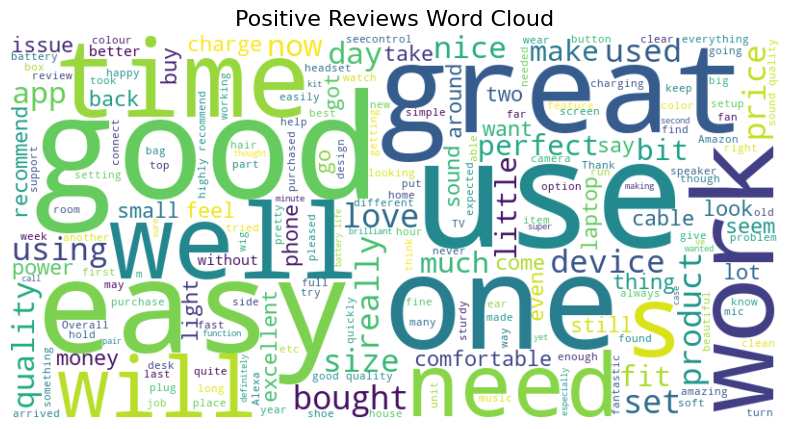

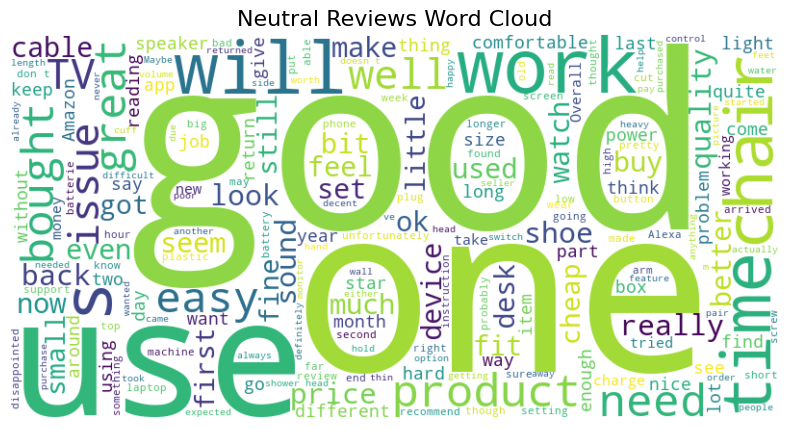

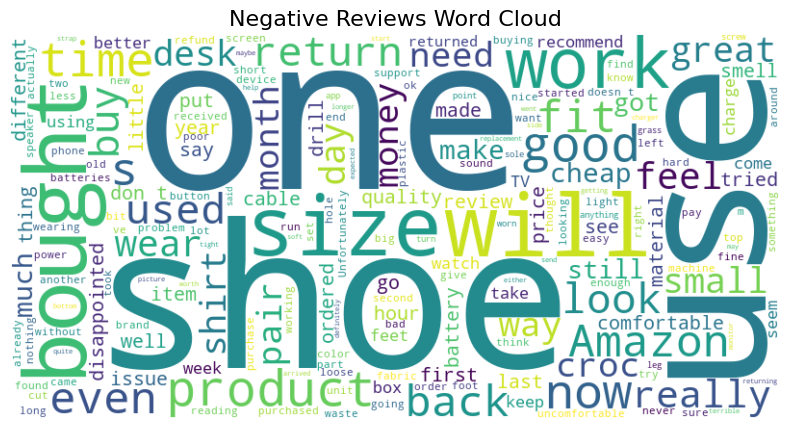

In [31]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Positive Reviews (RATING >= 4)
positive_reviews = combined_df[combined_df['Rating'] >= 4]['Review Content'].dropna().str.cat(sep=' ')
generate_wordcloud(positive_reviews, "Positive Reviews Word Cloud")

# Neutral Reviews (RATING == 3)
neutral_reviews = combined_df[combined_df['Rating'] == 3]['Review Content'].dropna().str.cat(sep=' ')
generate_wordcloud(neutral_reviews, "Neutral Reviews Word Cloud")

# Negative Reviews (RATING <= 2)
negative_reviews = combined_df[combined_df['Rating'] <= 2]['Review Content'].dropna().str.cat(sep=' ')
generate_wordcloud(negative_reviews, "Negative Reviews Word Cloud")

# 🔧 1.0 DATA CLEANING + NEGATION HANDLING

In [32]:
# Ensure consistent language detection
DetectorFactory.seed = 0

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update({"would", "shall", "could", "might"})
stop_words.discard("not")  # Retain "not" for sentiment analysis

### 1. DATA CLEANING & PREPROCESSING ###

# Function to check if a review is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Function to handle negations
def handle_negation(text):
    tokens = word_tokenize(text.lower())
    result = []
    negate = False
    for word in tokens:
        if word in {"not", "no", "never", "n't"}:
            negate = True
            result.append(word)
        elif negate:
            result.append("NOT_" + word)
            negate = False
        else:
            result.append(word)
    return result

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")                # Remove emojis
    text = re.sub(r"http\S+", "", text)                         # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)                     # Remove special characters & digits
    tokens = handle_negation(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)


### 2. APPLY TO DATAFRAME ###

# Step 1: Start clean - keep only needed columns and drop obvious problems
df_cleaned = combined_df[['Review Content', 'Rating']].drop_duplicates().dropna(subset=['Review Content'])

# Step 2: Check for English text only
df_cleaned = df_cleaned[df_cleaned['Review Content'].apply(lambda x: is_english(str(x)))]

# Step 3: Apply text cleaning
df_cleaned['cleaned_review'] = df_cleaned['Review Content'].apply(lambda x: clean_text(str(x)))

# Step 4: Create sentiment labels
df_cleaned["sentiment"] = df_cleaned["Rating"].apply(lambda x: "Positive" if x >= 4 else "Neutral" if x == 3 else "Negative")

# Done
df_cleaned.head()



,Review Content,Rating,cleaned_review,sentiment
0,"Same to this one as well, very classy and soft...",5.0,one well classy soft NOT_bad smell perfect nec...,Positive
1,"Beautiful colors, exactly what I wanted, but ...",4.0,beautiful color exactly wanted item defect,Positive
2,"This is top notch scarf, so soft and classy no...",5.0,top notch scarf soft classy NOT_smells perfect...,Positive
3,Item was great; would buy from seller again!,5.0,item great buy seller,Positive
4,Nice item,5.0,nice item,Positive


In [44]:
print(df_cleaned.shape)

print(df_cleaned.info())

(11253, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 11253 entries, 0 to 12619
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Content  11253 non-null  object 
 1   Rating          11154 non-null  float64
 2   cleaned_review  11253 non-null  object 
 3   sentiment       11253 non-null  object 
dtypes: float64(1), object(3)
memory usage: 439.6+ KB
None


### 3. MODEL SELECTION & TRAINING w/out smote and hyperparameters###

In [33]:

# TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df_cleaned["cleaned_review"])
y = df_cleaned["sentiment"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

In [34]:
### 3. MODEL SELECTION & TRAINING w/out smote and hyperparameters###
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute Class Weights (Handles Imbalance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


from imblearn.over_sampling import SMOTE

# Apply SMOTE to training set only
#sm = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

'''model_1 = Pipeline(
    steps=[
        #best base model("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)),
    ("classifier", LogisticRegression())]
)'''
log_reg=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs',
                            max_iter=200, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)


log_reg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=200, multi_class='auto')

In [45]:
print(X_train.shape, X_test.shape)

(9002, 4962) (2251, 4962)


              precision    recall  f1-score   support

           0       0.72      0.76      0.74       682
           1       0.46      0.32      0.37       352
           2       0.84      0.89      0.87      1217

    accuracy                           0.76      2251
   macro avg       0.67      0.66      0.66      2251
weighted avg       0.74      0.76      0.75      2251

AUC Score: 0.8440070875877451


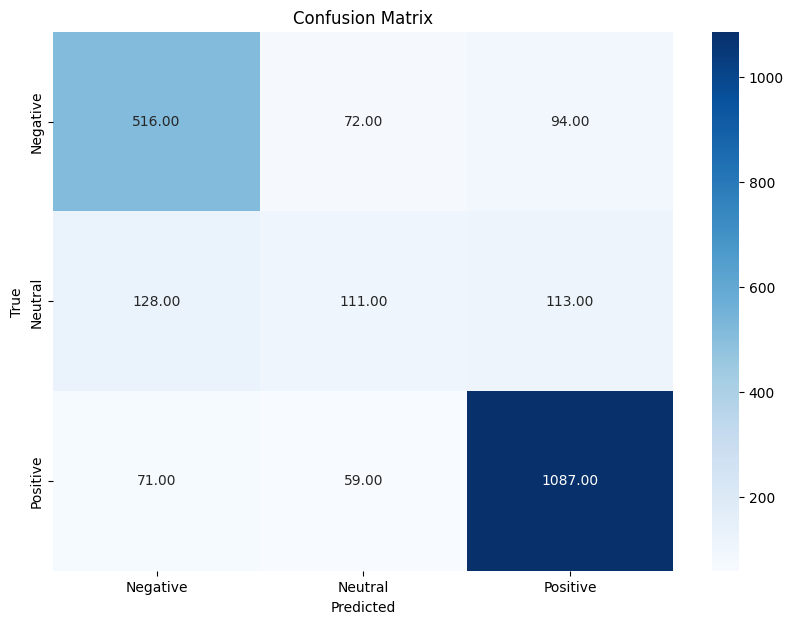

In [35]:
### 4. MODEL EVALUATION ###
# Make Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

# Evaluate Performance
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred) #normalize = 'all'
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Cleaned & Corrected Version (with SMOTE) _hyperparameters

# Hyperparameter tunnings

In [36]:
# Hyperparameter Tuning via GridSearchCV (Optional but recommended)
param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0, 6.0, 7.0 , 10.0 ],
    'max_iter': [1000, 2000, 5000],
    'solver': ['liblinear', 'saga'],
  #  'penalty': ['l1', 'l2'],
  #  'class_weight': [None, 'balanced']

}
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model from GridSearchCV
log_reg_best = grid_search.best_estimator_
log_reg_best 

Fitting 3 folds for each of 42 candidates, totalling 126 fits


LogisticRegression(C=5.0, max_iter=1000, multi_class='auto', solver='liblinear')

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       682
           1       0.39      0.44      0.41       352
           2       0.87      0.83      0.85      1217

    accuracy                           0.74      2251
   macro avg       0.66      0.67      0.67      2251
weighted avg       0.75      0.74      0.75      2251

AUC Score: 0.8386918457369644


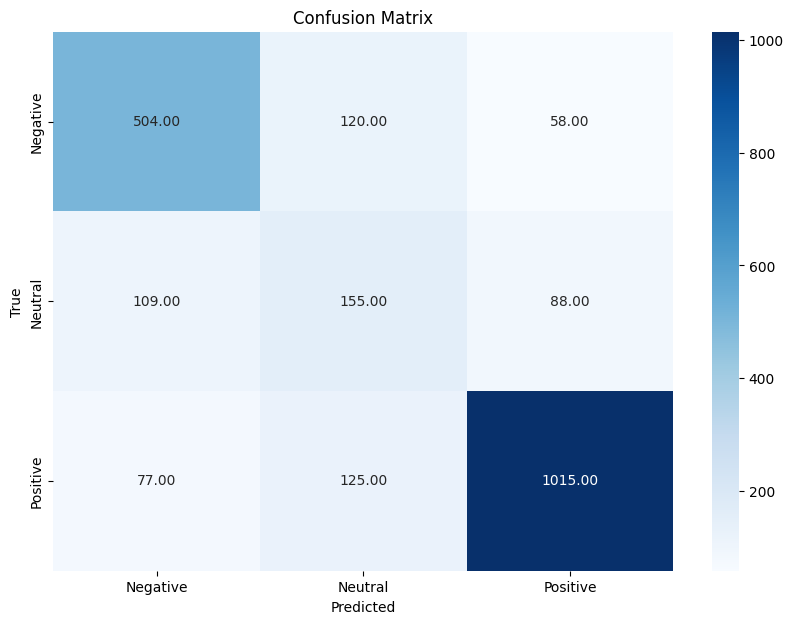

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df_cleaned["cleaned_review"])
y = df_cleaned["sentiment"]

# 2. Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. Feature Selection using Chi2
chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 5. Apply SMOTE (Oversampling)
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 6. Compute Class Weights (Optional if using SMOTE)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 7. Train Logistic Regression
##log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, solver="liblinear",multi_class='auto', C=6.0)

log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, 
             multi_class='auto', C=6.0,
             solver="liblinear",
             #solver="lbfgs",
           #  verbose=0, warm_start=False, n_jobs=None,
           #  penalty='l2', dual=False, tol=0.0001, 
             )

# # 7. Train Logistic Regression
# log_reg = LogisticRegression(
#     penalty='l2', dual=False, tol=0.0001, C=10,
#     solver='lbfgs', max_iter=200, multi_class='auto',
#     verbose=0, warm_start=False, n_jobs=None
# )

log_reg.fit(X_train_resampled, y_train_resampled)


# 8. Evaluate Model
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred) #normalize='all
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Model Explanation - LIME 

In [38]:
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

# Create pipeline (TF-IDF Vectorizer + Logistic Regression)
pipeline = make_pipeline(vectorizer, log_reg)

# Create LIME Text Explainer
class_names = label_encoder.classes_
explainer = lime.lime_text.LimeTextExplainer(class_names=class_names)

# Choose a random test review to explain
idx = np.random.randint(0, len(y_test))
sample_idx = X_test.indices[idx] if hasattr(X_test, 'indices') else idx
sample_text = df_cleaned.iloc[sample_idx]["cleaned_review"]

print("Selected Review Text:\n", sample_text)
print("\nTrue Sentiment:", label_encoder.inverse_transform([y_test[idx]])[0])

# Explain prediction
exp = explainer.explain_instance(
    sample_text, 
    pipeline.predict_proba, 
    num_features=10, 
    top_labels=1
)

# Instead of show_in_notebook, SAVE the explanation
exp.save_to_file('lime_explanation.html')
print("✅ LIME explanation saved. Open 'lime_explanation.html' to view it.")


Selected Review Text:
 bought loop gate itd stay closed exactly

True Sentiment: Positive
✅ LIME explanation saved. Open 'lime_explanation.html' to view it.


############################################

# WITH MLFLOW Tracking

In [39]:
# # ========================
# # 2. FEATURE ENGINEERING
# # ========================
# #df["SENTIMENT"] = df["RATING"].apply(lambda x: "Positive" if x >= 4 else "Neutral" if x == 3 else "Negative")

# vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
# X = vectorizer.fit_transform(df["cleaned_review"])
# y = df["sentiment"]

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# chi2_scores, _ = chi2(X, y_encoded)
# top_features = np.argsort(chi2_scores)[-5000:]
# X_selected = X[:, top_features]

# X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [40]:
# # ========================
# # 3. MODEL TRAINING WITH MLFLOW (LOGISTIC REGRESSION)
# # ========================
# class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# #mlflow.set_experiment("Sentiment Analysis")

# # Initialize MLflow
# mlflow.set_experiment("Sentiment Analysis")
# #mlflow.set_tracking_uri("http://localhost:5000")


# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")

# with mlflow.start_run(run_name="LogisticRegression"):
#     log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=2000, solver="liblinear", C=1.0)
#     log_reg.fit(X_train, y_train)
#     y_pred = log_reg.predict(X_test)
#     y_prob = log_reg.predict_proba(X_test)

#     mlflow.log_param("model", "LogisticRegression")
#     mlflow.log_metric("f1_score", f1_score(y_test, y_pred, average="macro"))
#     mlflow.log_metric("precision", precision_score(y_test, y_pred, average="macro"))
#     mlflow.log_metric("recall", recall_score(y_test, y_pred, average="macro"))
#     mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))
#     mlflow.sklearn.log_model(log_reg, "logistic_regression")


In [41]:
# # ========================
# # 4. MODEL TRAINING WITH MLFLOW (XGBOOST)
# # ========================
# with mlflow.start_run(run_name="XGBoost"):
#     xgb_clf = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False)
#     xgb_clf.fit(X_train, y_train)
#     y_pred = xgb_clf.predict(X_test)
#     y_prob = xgb_clf.predict_proba(X_test)

#     mlflow.log_param("model", "XGBoost")
#     mlflow.log_metric("f1_score", f1_score(y_test, y_pred, average="macro"))
#     mlflow.log_metric("precision", precision_score(y_test, y_pred, average="macro"))
#     mlflow.log_metric("recall", recall_score(y_test, y_pred, average="macro"))
#     mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))
#     mlflow.xgboost.log_model(xgb_clf, "xgboost_model")